In [6]:
from numpy import all, any, array, arctan2, cos, sin, exp, dot, log, logical_and, roll, sqrt, stack, trace, unravel_index, pi, deg2rad, rad2deg, where, zeros, floor, full, nan, isnan, round, float32
import numpy as np
from numpy.linalg import det, lstsq, norm
from cv2 import resize, GaussianBlur, subtract, KeyPoint, INTER_LINEAR, INTER_NEAREST, imread
from functools import cmp_to_key
import logging
import matplotlib.pyplot as plt

In [7]:
img = imread('all_souls_000002.jpg', 0)
print(img.shape)

(1024, 677)


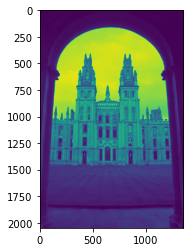

In [13]:
resized_img = resize(img, (0, 0), fx=2, fy=2, interpolation=INTER_LINEAR)
plt.imshow(resized_img)
plt.show()

# Parameters

In [225]:
sigma=1.6
num_intervals=3
assumed_blur=0.5
image_border_width=5
float_tolerance = 1e-7

# Part 1

In [8]:
# base image = our image

def number_of_octaves(image):
    return int(np.log(min(image.shape))/np.log(2) -1)

In [29]:
num_octaves = number_of_octaves(img)

In [18]:
def initial_blur(image, sigma, assumed_blur):

    # Multiply the size of the image by two
    image = resize(image, (0, 0), fx=2, fy=2, interpolation=INTER_LINEAR)

    # set a value of initial blur
    sig = np.sqrt(max((sigma ** 2) - ((2 * assumed_blur) ** 2), 0.01))

    # set initial blur to sigma
    return GaussianBlur(image, (0, 0), sigmaX=sig, sigmaY=sig)

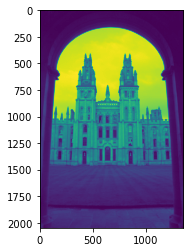

In [20]:
init_img = initial_blur(img, sigma, assumed_blur)
plt.imshow(init_img)
plt.show()

In [21]:
def gaussian_kernel(sigma, num_sets):

    # Initializing the blur_scale by sigma
    num_img = num_sets + 3
    k = 2**(1/num_sets)
    blur_scale = np.zeros(num_img)
    blur_scale[0] = sigma

    # multiplying the blur by 2**(1/s) to achieve twice the blur
    for i in range(1, num_img):
        sigma_previous = k**(i-1) * sigma
        sigma_after = k * sigma_previous
        blur_scale[i] = np.sqrt(sigma_after**2 - sigma_previous**2)

    return blur_scale

In [23]:
blur_scale = gaussian_kernel(sigma, num_intervals)
print(blur_scale)

[1.6        1.2262735  1.54500779 1.94658784 2.452547   3.09001559]


In [38]:
def generate_octaves(image, num_octaves, blur_scale):

    octaves = []

    # Computing num_ocatves, each with num_sets images
    for i in range(num_octaves):
        octave =  []
        octave.append(image)

        for blur in blur_scale[1:]:
            image = GaussianBlur(image, (0, 0), sigmaX=blur, sigmaY=blur)
            octave.append(image)
        octaves.append(octave)

        # Resizing the image (division by 2) to use it as base for next octave
        new_base = octave[-3]
        image = resize(new_base, (int(new_base.shape[1] / 2), int(new_base.shape[0] / 2)), interpolation=INTER_NEAREST)

    return np.array(octaves, dtype=object)

In [55]:
octaves = generate_octaves(img, num_octaves, blur_scale)
print(octaves)

[[array([[ 4,  3,  2, ...,  2,  2,  2],
       [ 2,  2,  2, ...,  2,  2,  1],
       [ 3,  3,  2, ...,  2,  2,  1],
       ...,
       [23, 22, 21, ...,  1,  2,  2],
       [18, 19, 21, ...,  3,  4,  3],
       [17, 20, 24, ...,  2,  3,  2]], dtype=uint8)
  array([[ 3,  2,  2, ...,  2,  2,  2],
       [ 3,  3,  2, ...,  2,  2,  2],
       [ 3,  3,  3, ...,  2,  2,  2],
       ...,
       [22, 22, 22, ...,  2,  3,  3],
       [20, 21, 21, ...,  2,  3,  3],
       [20, 20, 21, ...,  2,  3,  3]], dtype=uint8)
  array([[ 3,  3,  2, ...,  2,  2,  2],
       [ 3,  3,  2, ...,  2,  2,  2],
       [ 3,  3,  3, ...,  2,  2,  2],
       ...,
       [22, 22, 23, ...,  3,  3,  3],
       [22, 22, 22, ...,  3,  3,  3],
       [21, 21, 22, ...,  2,  3,  3]], dtype=uint8)
  array([[ 3,  3,  3, ...,  2,  2,  2],
       [ 3,  3,  3, ...,  2,  2,  2],
       [ 3,  3,  3, ...,  2,  2,  2],
       ...,
       [23, 23, 24, ...,  3,  3,  3],
       [23, 23, 23, ...,  3,  3,  3],
       [23, 23, 23, ...,  3,

In [63]:
def generate_DOG_octaves(gaussian_octaves):

    dog_octaves = []

    for octave in gaussian_octaves:
        dog_oct = []
        for i in range(1,len(octave)):
            dog_oct.append(subtract(octave[i], octave[i-1]))
        dog_octaves.append(dog_oct)

    return array(dog_octaves, dtype=object)

In [65]:
dog_octaves = generate_DOG_octaves(octaves)
print(dog_octaves[0][0])

[[0 0 0 ... 0 0 0]
 [1 1 0 ... 0 0 1]
 [0 0 1 ... 0 0 1]
 ...
 [0 0 1 ... 1 1 1]
 [2 2 0 ... 0 0 0]
 [3 0 0 ... 0 0 1]]


# Part 2

In [94]:
def grad_and_hessian(im):

    #computing the gradient
    dx = (im[1, 1, 2] - im[1, 1, 0])/2
    dy = (im[1, 2, 1] - im[1, 0, 1])/2
    ds = (im[2, 1, 1] - im[0, 1, 1])/2

    grad = np.array([dx, dy, ds])

    #computing the Hessian
    cpixel = im[1, 1, 1]
    dxx = im[1, 1, 2] - 2 * cpixel + im[1, 1, 0]
    dyy = im[1, 2, 1] - 2 * cpixel + im[1, 0, 1]
    dss = im[2, 1, 1] - 2 * cpixel + im[0, 1, 1]
    dxy = (im[1, 2, 2] - im[1, 2, 0] - im[1, 0, 2] + im[1, 0, 0])/4
    dxs = (im[2, 1, 2] - im[2, 1, 0] - im[0, 1, 2] + im[0, 1, 0])/4
    dys = (im[2, 2, 1] - im[2, 0, 1] - im[0, 2, 1] + im[0, 0, 1])/4

    hess =  np.array([[dxx, dxy, dxs], 
                  [dxy, dyy, dys],
                  [dxs, dys, dss]])

    return grad, hess

In [80]:
def is_extremum(im1, im2, im3, thresh):

    # checks if the middle pixel is an extremum
    n, p = im1.shape
    new_sub_im = np.zeros((n,p,3))
    new_sub_im[:,:,0] = im1
    new_sub_im[:,:,1] = im2
    new_sub_im[:,:,2] = im3
    # take the pixel in the middle of the 3x3x3 subimage
    interest_pixel = im2[1,1]

    if abs(interest_pixel) > thresh:
        if interest_pixel == np.amax(new_sub_im):
            return True
        elif interest_pixel == np.amin(new_sub_im):
            return True
    return False

In [105]:
def in_image(i, j, width, image_shape0, image_shape1, img_ind, num_sets):

    if i < width or i >= image_shape0 - width or j < width or j >= image_shape1 - width or img_ind < 1 or img_ind > num_intervals:
        return True
    return False

In [314]:
print(int(round(6.55)))
print(round(6.45))

7
6.0


In [147]:
def localize_extremum(i, j, img_ind, oct_ind, num_sets, dog_oct, sigma, thresh, width, r=10, max_iter=5):

    # starting with the keypoint inside the image
    loc_out = False

    image_shape = dog_oct[0].shape

    for cpt in range(max_iter):
        im1, im2, im3 = dog_oct[img_ind-1:img_ind+2]

        #convert pixel values to values between (0,1) to apply Lowe's thresh
        interest_area = stack([im1[i-1:i+2, j-1:j+2], im2[i-1:i+2, j-1:j+2], im3[i-1:i+2, j-1:j+2]]).astype('float32') / 255

        grad, hess = grad_and_hessian(interest_area)

        extremum_update = -lstsq(hess, grad, rcond=None)[0]

        max_abs = np.amax(abs(extremum_update))
        if max_abs < 0.5:
            break
        
        j += int(round(extremum_update[0]))
        i += int(round(extremum_update[1]))
        img_ind += int(round(extremum_update[2])) 

        if in_image(i, j, width, image_shape[0], image_shape[1], img_ind, num_sets):
            loc_out = True
            break
        
    if loc_out:
        return None

    if cpt >= max_iter:
        return None

    new_extrema = interest_area[1,1,1] + np.dot(grad, extremum_update)/2

    # check first condition
    if abs(new_extrema)*num_sets >= thresh:

        # check second condition
        trace_hess = np.trace(hess[:2, :2])
        determinant = det(hess[:2, :2])

        if determinant > 0 and r * trace_hess < (r+1)*determinant:
            # creating a keypoint class
            keypoint = KeyPoint()
            keypoint.pt = ((j + extremum_update[0]) * (2 ** oct_ind), (i + extremum_update[1]) * (2 ** oct_ind))
            keypoint.octave = oct_ind + img_ind * (2 ** 8) + int(round((extremum_update[2] + 0.5) * 255)) * (2 ** 16)
            keypoint.size = sigma * (2 ** ((img_ind + extremum_update[2]) / float32(num_sets))) * (2 ** (oct_ind + 1))
            keypoint.response = abs(new_extrema)

            return keypoint, img_ind

    return None

# Part 3

In [201]:
# fonction par encore modifiée pour l'instant

def compute_orientations(keypoint, octave_index, gaussian_image, radius_factor=3, num_bins=36, peak_ratio=0.8, scale_factor=1.5):
    """Compute orientations for each keypoint
    """
    keypoints_with_orientations = []
    image_shape = gaussian_image.shape

    scale = scale_factor * keypoint.size / float32(2 ** (octave_index + 1))  # compare with keypoint.size computation in localizeExtremumViaQuadraticFit()
    radius = int(round(radius_factor * scale))
    weight_factor = -0.5 / (scale ** 2)
    raw_histogram = zeros(num_bins)
    smooth_histogram = zeros(num_bins)

    for i in range(-radius, radius + 1):
        region_y = int(round(keypoint.pt[1] / float32(2 ** octave_index))) + i
        if region_y > 0 and region_y < image_shape[0] - 1:
            for j in range(-radius, radius + 1):
                region_x = int(round(keypoint.pt[0] / float32(2 ** octave_index))) + j
                if region_x > 0 and region_x < image_shape[1] - 1:
                    dx = gaussian_image[region_y, region_x + 1] - gaussian_image[region_y, region_x - 1]
                    dy = gaussian_image[region_y - 1, region_x] - gaussian_image[region_y + 1, region_x]
                    gradient_magnitude = sqrt(dx * dx + dy * dy)
                    gradient_orientation = rad2deg(arctan2(dy, dx))
                    weight = exp(weight_factor * (i ** 2 + j ** 2))  # constant in front of exponential can be dropped because we will find peaks later
                    histogram_index = int(round(gradient_orientation * num_bins / 360.))
                    raw_histogram[histogram_index % num_bins] += weight * gradient_magnitude

    for n in range(num_bins):
        smooth_histogram[n] = (6 * raw_histogram[n] + 4 * (raw_histogram[n - 1] + raw_histogram[(n + 1) % num_bins]) + raw_histogram[n - 2] + raw_histogram[(n + 2) % num_bins]) / 16.
    orientation_max = max(smooth_histogram)
    orientation_peaks = where(logical_and(smooth_histogram > roll(smooth_histogram, 1), smooth_histogram > roll(smooth_histogram, -1)))[0]
    for peak_index in orientation_peaks:
        peak_value = smooth_histogram[peak_index]
        if peak_value >= peak_ratio * orientation_max:
            left_value = smooth_histogram[(peak_index - 1) % num_bins]
            right_value = smooth_histogram[(peak_index + 1) % num_bins]
            interpolated_peak_index = (peak_index + 0.5 * (left_value - right_value) / (left_value - 2 * peak_value + right_value)) % num_bins
            orientation = 360. - interpolated_peak_index * 360. / num_bins
            if abs(orientation - 360.) < float_tolerance:
                orientation = 0
            new_keypoint = KeyPoint(*keypoint.pt, keypoint.size, orientation, keypoint.response, keypoint.octave)
            keypoints_with_orientations.append(new_keypoint)
    return keypoints_with_orientations

In [317]:
def all_keypoints(gaussian_octaves, dog_octaves, num_sets, sigma, width, thresh=0.04):


    threshold = floor(0.5 * thresh / num_intervals * 255) #from opencv implementation
    all_keypoints = []

    for oct_ind, dog_oct in enumerate(dog_octaves):
        for img_ind, (im1, im2, im3) in enumerate(zip(dog_oct, dog_oct[1:], dog_oct[2:])):
            n , p = im1.shape[0], im1.shape[1]
            for i in range(width, n-width):
                for j in range(width, p-width):
                    if is_extremum(im1[i-1:i+2, j-1:j+2], im2[i-1:i+2, j-1:j+2], im3[i-1:i+2, j-1:j+2], threshold):
                        loc = localize_extremum(i, j, img_ind + 1, oct_ind, num_sets, dog_oct, sigma, thresh, width)
                        if loc is not None:
                            keypoint, localization = loc
                            keypoints_oriented = compute_orientations(keypoint, oct_ind, gaussian_octaves[oct_ind][localization])

                            for kp in keypoints_oriented:
                                all_keypoints.append(kp)
    return all_keypoints

In [318]:
keypoints = all_keypoints(octaves, dog_octaves, num_intervals, sigma, image_border_width)

IndexError: tuple index out of range

In [228]:
print(len(keypoints))
print(keypoints)

4644
[<KeyPoint 000001B85511BEA0>, <KeyPoint 000001B85582FF90>, <KeyPoint 000001B85582F7B0>, <KeyPoint 000001B85582F0C0>, <KeyPoint 000001B85582FF60>, <KeyPoint 000001B85582F660>, <KeyPoint 000001B8556B02D0>, <KeyPoint 000001B8556B0C00>, <KeyPoint 000001B8556B01B0>, <KeyPoint 000001B8556B0AE0>, <KeyPoint 000001B8556B0030>, <KeyPoint 000001B8556B0090>, <KeyPoint 000001B8556B07E0>, <KeyPoint 000001B8556B0870>, <KeyPoint 000001B8556B0AB0>, <KeyPoint 000001B8556B0CC0>, <KeyPoint 000001B8556B0BD0>, <KeyPoint 000001B8556B0C60>, <KeyPoint 000001B8556B0B10>, <KeyPoint 000001B8556B0C90>, <KeyPoint 000001B8556B01E0>, <KeyPoint 000001B8556B07B0>, <KeyPoint 000001B8556B00C0>, <KeyPoint 000001B8556B0BA0>, <KeyPoint 000001B8556B0840>, <KeyPoint 000001B8556B0180>, <KeyPoint 000001B854120330>, <KeyPoint 000001B854120BA0>, <KeyPoint 000001B854120450>, <KeyPoint 000001B854120480>, <KeyPoint 000001B8541202D0>, <KeyPoint 000001B854120FC0>, <KeyPoint 000001B854120660>, <KeyPoint 000001B854120CC0>, <KeyPoin

# Harris

In [250]:
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter, filters

def convolve_Sobel(img):
    
    kernel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
    kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    
    Ix = convolve2d(img, kernel_x, mode='same')
    Iy = convolve2d(img, kernel_y, mode='same')
    
    return Ix, Iy

def harris_corner_detector(img):
    
    m, n = img.shape
    thresh = 10**7
    
    Ix, Iy = convolve_Sobel(img)
    
    Ixx = gaussian_filter(Ix**2, sigma=1)
    Ixy = gaussian_filter(Ix*Iy, sigma=1)
    Iyy = gaussian_filter(Iy**2, sigma=1)
    
    k = 0.05
    detH = Ixx*Iyy - Ixy**2
    traceH = Ixx + Iyy
    
    R = detH - k*(traceH**2)
    
    img_corners = np.zeros((m,n))
    for i in range(1, m-1):
        for j in range(1, n-1):
            if R[i,j] > thresh and R[i, j] > R[i - 1, j - 1] and R[i, j] > R[i - 1, j + 1] and R[i, j] > R[i + 1, j - 1] and R[i, j] > R[i + 1, j + 1]:
                img_corners[i,j] = 255
    return img_corners

In [251]:
def generate_scales(image, num_octaves):

    image_set = [image]

    # Computing num_ocatves, each with num_sets images
    for i in range(1, num_octaves):
        image = resize(image, (int(image.shape[1]*(3/4)), int(image.shape[0]*(3/4))), interpolation=INTER_LINEAR)
        image_set.append(image)

    return image_set

In [260]:
def storing_corners(img_corners):
    x_list = np.where(img_corners > 0)[0]
    y_list = np.where(img_corners > 0)[1]
    # scale_list = scale*np.array([1 for i in range(len(x_list))])
    return np.vstack((x_list, y_list)).T

In [307]:
def keypoints_for_harris(octaves):

    all_keypoints = []

    for i, img in enumerate(octaves):

        img_corners = harris_corner_detector(img)
        keypoints = storing_corners(img_corners)
        for keyp in keypoints:

            keypoint = KeyPoint()
            keypoint.pt = (keyp[1], keyp[0])
            keypoint.octave = i
            keypoint.size = 1
            keypoint.response = 1

            keypoints_oriented = compute_orientations(keypoint, i, img)

            for kp in keypoints_oriented:
                all_keypoints.append(kp)
    return all_keypoints

In [308]:
octaves = generate_scales(img, num_octaves)
kp = keypoints_for_harris(octaves)

In [303]:
def resizing(keypoints):
    for kp in keypoints:
        octa = kp.octave
        kp.pt = (kp.pt[0]*(4/3)**octa, kp.pt[1]*(4/3)**octa)

In [309]:
resizing(kp)

In [310]:
def plotting_keypoints(keyp, img):
    x_list = []
    y_list = []
    for kp in keyp:
        kx, ky = kp.pt[0], kp.pt[1]
        x_list.append(kx)
        y_list.append(ky)
    plt.imshow(img)
    plt.plot(x_list,y_list, 'o')
    plt.show()

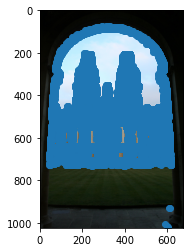

In [311]:
plotting_keypoints(kp, plt.imread('all_souls_000002.jpg'))